In [1]:
# ==========================================
# 0. Imports & Device
# ==========================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 재현성(선택)
torch.manual_seed(42)
np.random.seed(42)

c:\Users\tkdwl\anaconda3\envs\rna_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
# ==========================================
# 1. Load Data
# ==========================================
train_seq = pd.read_csv('train_sequences.csv')
train_labels = pd.read_csv('train_labels.csv')

print(f"Sequence data shape: {train_seq.shape}")
print(f"Label data shape: {train_labels.shape}")

C:\Users\tkdwl\AppData\Local\Temp\ipykernel_16680\1611923536.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  train_labels = pd.read_csv('train_labels.csv')


Sequence data shape: (5716, 8)
Label data shape: (7794971, 8)


In [3]:
# ==========================================
# 2. Tokenize sequences (A,C,G,U -> 1..4, PAD=0)
# ==========================================
mapping = {'A': 1, 'C': 2, 'G': 3, 'U': 4}
train_seq['tokenized'] = train_seq['sequence'].apply(lambda x: [mapping.get(base, 0) for base in str(x)])

In [4]:
# ==========================================
# 3. Label preprocessing: build coordinates + coord_mask (remove NaN/Inf from labels safely)
# ==========================================
# - ID가 "target_resid" 형태라고 가정하고 target_id를 분리
train_labels['target_id'] = train_labels['ID'].astype(str).str.rsplit('_', n=1).str[0]

# resid 정리
if 'resid' in train_labels.columns:
    train_labels['resid'] = pd.to_numeric(train_labels['resid'], errors='coerce')
    train_labels = train_labels.dropna(subset=['resid']).copy()
    train_labels['resid'] = train_labels['resid'].astype(int)
else:
    # resid가 없다면 정렬 기준이 약해짐(가능하면 resid 있는지 확인 추천)
    train_labels['resid'] = 0

train_labels = train_labels.sort_values(['target_id', 'resid'])

# x/y/z 숫자화 (문자열 'nan', 'inf' 등 강제 처리)
xyz_cols = ['x_1', 'y_1', 'z_1']
for c in xyz_cols:
    train_labels[c] = pd.to_numeric(train_labels[c], errors='coerce')

# 좌표 유효 마스크(1: 유효, 0: 결측/inf)
arr = train_labels[xyz_cols].to_numpy(dtype=np.float64)
finite_row = np.isfinite(arr).all(axis=1) & (np.abs(arr) < 1e17).all(axis=1)
train_labels['coord_ok'] = finite_row.astype(np.float32)

# 결측 처리도 같이
train_labels.loc[~finite_row, xyz_cols] = 0.0
train_labels[xyz_cols] = train_labels[xyz_cols].astype(np.float32)


# NaN/Inf를 0으로 치환 (중요: loss NaN 전염 방지)
train_labels[xyz_cols] = (
    train_labels[xyz_cols]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0.0)
    .astype(np.float32)
)

# 너무 결측이 많은 target 제거(옵션)
min_valid_points = 10
valid_counts = train_labels.groupby('target_id')['coord_ok'].sum()
good_ids = valid_counts[valid_counts >= min_valid_points].index
train_labels = train_labels[train_labels['target_id'].isin(good_ids)].copy()
print(f"[Label Filter] valid points < {min_valid_points} 제거 후 labels shape:", train_labels.shape)

# target별 coordinates / coord_mask 만들기
train_labels = train_labels.sort_values(['target_id', 'resid'])

coords_df = (
    train_labels.groupby('target_id')[xyz_cols]
    .apply(lambda x: x.to_numpy(dtype=np.float32).tolist())
    .reset_index(name='coordinates')
)

mask_df = (
    train_labels.groupby('target_id')['coord_ok']
    .apply(lambda x: x.to_numpy(dtype=np.float32).tolist())
    .reset_index(name='coord_mask')
)

coords_df = coords_df.merge(mask_df, on='target_id', how='inner')

# merge 키 정리
train_seq['target_id'] = train_seq['target_id'].astype(str).str.strip()
coords_df['target_id'] = coords_df['target_id'].astype(str).str.strip()

# 서열 + 좌표 병합
train_df = train_seq.merge(coords_df, on='target_id', how='inner')
print("train_seq:", train_seq.shape)
print("coords_df:", coords_df.shape)
print("train_df:", train_df.shape)
assert len(train_df) > 0, "merge 결과가 비었습니다: target_id 키 매칭이 안 됩니다."
MAX_LEN = 200
train_df['valid_in_window'] = train_df['coord_mask'].apply(
    lambda m: float(np.sum(np.asarray(m, dtype=np.float32)[:MAX_LEN]))
)

# 예: 앞 200개 중 유효 좌표가 10개 미만이면 제거
train_df = train_df[train_df['valid_in_window'] >= 10].copy()
print("Filtered train_df:", train_df.shape)

# 최종 sanity check: coordinates에 NaN/Inf 없어야 함
def coord_has_nan_inf(coords):
    a = np.asarray(coords, dtype=np.float32)
    return (not np.isfinite(a).all())

bad = train_df['coordinates'].apply(coord_has_nan_inf)
print("NaN/Inf 좌표 샘플 수(정제 후):", bad.sum())

# 길이 체크(참고)
train_df['seq_len'] = train_df['sequence'].str.len()
train_df['coord_len'] = train_df['coordinates'].apply(len)
mismatch = train_df['seq_len'] != train_df['coord_len']
print("길이 불일치 샘플 수:", mismatch.sum())
if mismatch.sum() > 0:
    print(train_df.loc[mismatch, ['target_id','seq_len','coord_len']].head())

[Label Filter] valid points < 10 제거 후 labels shape: (7794919, 10)
train_seq: (5716, 9)
coords_df: (5711, 3)
train_df: (5711, 11)
Filtered train_df: (5708, 12)
NaN/Inf 좌표 샘플 수(정제 후): 0
길이 불일치 샘플 수: 0


In [5]:
# ==========================================
# 4. Kabsch RMSD Loss (mask supported, and correct SVD handling)
# ==========================================
def kabsch_rotation(P, Q, mask=None):
    """
    P, Q: (B, N, 3)
    mask: (B, N)  1(valid), 0(invalid/pad)
    """
    if mask is None:
        mask = torch.ones(P.shape[0], P.shape[1], device=P.device, dtype=P.dtype)

    mask_exp = mask.unsqueeze(-1)  # (B,N,1)
    mask_sum = mask_exp.sum(dim=1, keepdim=True).clamp_min(1e-8)

    P_mean = (P * mask_exp).sum(dim=1, keepdim=True) / mask_sum
    Q_mean = (Q * mask_exp).sum(dim=1, keepdim=True) / mask_sum

    P_c = (P - P_mean) * mask_exp
    Q_c = (Q - Q_mean) * mask_exp

    H = torch.matmul(P_c.transpose(1, 2), Q_c)  # (B,3,3)

    # torch.linalg.svd returns U,S,Vh
    U, S, Vh = torch.linalg.svd(H, full_matrices=False)
    V = Vh.transpose(1, 2)

    det = torch.det(torch.matmul(V, U.transpose(1, 2)))
    sign = torch.where(det < 0, -torch.ones_like(det), torch.ones_like(det))

    E = torch.eye(3, device=P.device, dtype=P.dtype).unsqueeze(0).repeat(P.shape[0], 1, 1)
    E[:, 2, 2] = sign

    R = torch.matmul(torch.matmul(V, E), U.transpose(1, 2))  # (B,3,3)
    P_aligned = torch.matmul(P_c, R.transpose(1, 2)) + Q_mean

    return P_aligned * mask_exp


class KabschRMSDLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, preds, target, mask):
        """
        preds : (B, K, N, 3)
        target: (B, N, 3)
        mask  : (B, N) 1(valid), 0(invalid/pad)
        """
        B, K, N, _ = preds.shape
        losses = []
        for k in range(K):
            pred_k = preds[:, k, :, :]
            pred_aligned = kabsch_rotation(pred_k, target, mask)

            diff_sq = (pred_aligned - target) ** 2
            sum_sq = (diff_sq * mask.unsqueeze(-1)).sum(dim=(1, 2))  # (B,)
            n_valid = (mask.sum(dim=1) * 3).clamp_min(1.0)           # (B,)
            mse = sum_sq / n_valid
            rmsd = torch.sqrt(mse + 1e-8)
            losses.append(rmsd)

        losses = torch.stack(losses, dim=1)  # (B,K)
        min_loss, _ = torch.min(losses, dim=1)
        return torch.mean(min_loss)

In [6]:
# ==========================================
# 5. Dataset (uses coord_mask to ignore missing labels)
# ==========================================
class RNADataset(Dataset):
    def __init__(self, sequences, coordinates, coord_masks, max_len=200):
        self.sequences = sequences
        self.coordinates = coordinates
        self.coord_masks = coord_masks
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        coords = np.asarray(self.coordinates[idx], dtype=np.float32)
        c_mask = np.asarray(self.coord_masks[idx], dtype=np.float32)

        # 안전하게 길이 맞추기
        L = min(len(seq), coords.shape[0], c_mask.shape[0], self.max_len)

        # seq padding
        seq_padded = np.zeros(self.max_len, dtype=np.int64)
        seq_padded[:L] = np.asarray(seq[:L], dtype=np.int64)

        # coords padding
        coords_padded = np.zeros((self.max_len, 3), dtype=np.float32)
        coords_padded[:L] = coords[:L]

        # 최종 mask: 라벨 유효(coord_ok)만 1 (패딩/결측은 0)
        mask = np.zeros(self.max_len, dtype=np.float32)
        mask[:L] = c_mask[:L]

        return (
            torch.tensor(seq_padded, dtype=torch.long),
            torch.tensor(coords_padded, dtype=torch.float32),
            torch.tensor(mask, dtype=torch.float32),
        )

In [7]:
# ==========================================
# 6. Train/Val split & DataLoaders
# ==========================================
train_idx, val_idx = train_test_split(range(len(train_df)), test_size=0.1, random_state=42)

train_dataset = RNADataset(
    train_df.iloc[train_idx]['tokenized'].values,
    train_df.iloc[train_idx]['coordinates'].values,
    train_df.iloc[train_idx]['coord_mask'].values,
    max_len=200
)
val_dataset = RNADataset(
    train_df.iloc[val_idx]['tokenized'].values,
    train_df.iloc[val_idx]['coordinates'].values,
    train_df.iloc[val_idx]['coord_mask'].values,
    max_len=200
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [8]:
# ==========================================
# 7. Model (Transformer + padding mask for attention)
# ==========================================
class RNATransformer(nn.Module):
    def __init__(self, n_tokens=5, d_model=128, nhead=8, num_layers=4, dropout=0.1, num_preds=5):
        super().__init__()
        self.embedding = nn.Embedding(n_tokens, d_model, padding_idx=0)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 1000, d_model))

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        self.num_preds = num_preds
        self.fc_coords = nn.Linear(d_model, 3 * num_preds)

    def forward(self, tokens):
        # tokens: (B,T)
        B, T = tokens.shape
        padding_mask = (tokens == 0)  # True at PAD positions

        x = self.embedding(tokens)
        x = x + self.pos_encoder[:, :T, :]
        x = self.transformer_encoder(x, src_key_padding_mask=padding_mask)

        out = self.fc_coords(x)  # (B,T,3*K)
        out = out.view(B, T, self.num_preds, 3).permute(0, 2, 1, 3)  # (B,K,T,3)
        return out

model = RNATransformer(num_preds=5).to(device)
print("Model Initialized (Best-of-5 Output Strategy).")


Model Initialized (Best-of-5 Output Strategy).


In [9]:
# ==========================================
# 8. Train (robust batch filtering)
# ==========================================
criterion = KabschRMSDLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-2)  # 더 안정적으로
epochs = 5

print(f"Starting Training for {epochs} epochs...")

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    n_steps = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for seq, target, mask in pbar:
        seq = seq.to(device)
        target = target.to(device)
        mask = mask.to(device)

        # ===== 핵심: 유효 포인트 부족 샘플 제거 =====
        # Kabsch는 최소 3점(=3 residues) 이상이 있어야 회전 정렬이 의미가 있고 수치적으로 안전함
        valid_counts = mask.sum(dim=1)  # (B,)
        keep = valid_counts >= 10       # 여기서 10은 안전 마진(3보다 크게 추천)

        if keep.sum() < 2:
            # 배치에 남는 샘플이 너무 적으면 그냥 스킵
            continue

        seq = seq[keep]
        target = target[keep]
        mask = mask[keep]

        optimizer.zero_grad(set_to_none=True)

        preds = model(seq)
        loss = criterion(preds, target, mask)

        if not torch.isfinite(loss):
            # 여기까지 왔는데도 NaN이면, 더 강한 방어 로깅
            print("Warning: Loss is NaN/Inf even after filtering. Skipping batch.")
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss += loss.item()
        n_steps += 1
        pbar.set_postfix({'loss': float(loss.item()), 'kept': int(keep.sum())})

    avg_loss = train_loss / max(1, n_steps)
    print(f"Epoch {epoch+1} Average Train Loss: {avg_loss:.6f} (steps={n_steps})")


Starting Training for 5 epochs...


Epoch 1/5: 100%|██████████| 161/161 [00:15<00:00, 10.60it/s, loss=15.8, kept=17]


Epoch 1 Average Train Loss: 18.665721 (steps=161)


Epoch 2/5: 100%|██████████| 161/161 [00:14<00:00, 11.29it/s, loss=23.1, kept=17]


Epoch 2 Average Train Loss: 18.648682 (steps=161)


Epoch 3/5: 100%|██████████| 161/161 [00:15<00:00, 10.21it/s, loss=14.6, kept=17]


Epoch 3 Average Train Loss: 18.616824 (steps=161)


Epoch 4/5: 100%|██████████| 161/161 [00:15<00:00, 10.31it/s, loss=23.9, kept=17]


Epoch 4 Average Train Loss: 18.631469 (steps=161)


Epoch 5/5: 100%|██████████| 161/161 [00:16<00:00, 10.01it/s, loss=14.4, kept=17]

Epoch 5 Average Train Loss: 18.318486 (steps=161)


In [10]:
# ==========================================
# 9. Validation
# ==========================================
model.eval()
val_loss = 0.0

with torch.no_grad():
    for seq, target, mask in val_loader:
        seq = seq.to(device)
        target = target.to(device)
        mask = mask.to(device)

        preds = model(seq)
        loss = criterion(preds, target, mask)

        if torch.isfinite(loss):
            val_loss += loss.item()

val_rmsd = val_loss / max(1, len(val_loader))
print(f"Validation RMSD (masked): {val_rmsd:.6f}")


c:\Users\tkdwl\anaconda3\envs\rna_env\lib\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Validation RMSD (masked): 18.679925


In [11]:
# ==========================================
# 10. Visualization (uses mask correctly)
# ==========================================
seq_batch, target_batch, mask_batch = next(iter(val_loader))
seq_batch = seq_batch.to(device)
target_batch = target_batch.to(device)
mask_batch = mask_batch.to(device)

with torch.no_grad():
    pred_batch = model(seq_batch)  # (B,5,T,3)

mask0 = mask_batch[0].detach().cpu().numpy().astype(bool)
t0 = target_batch[0].detach().cpu().numpy()[mask0]     # (L_valid,3)
p0 = pred_batch[0, 0].detach().cpu().numpy()[mask0]    # pred k=0

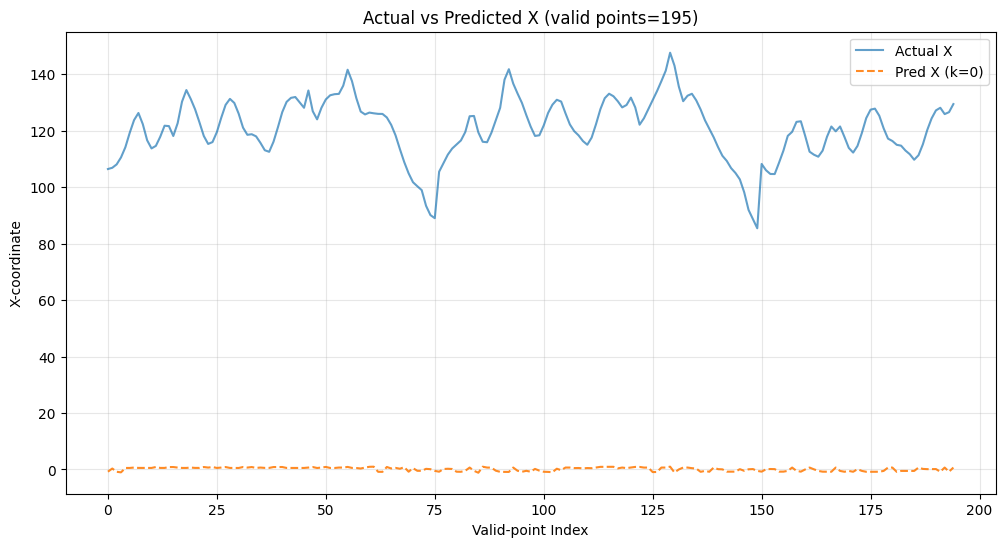

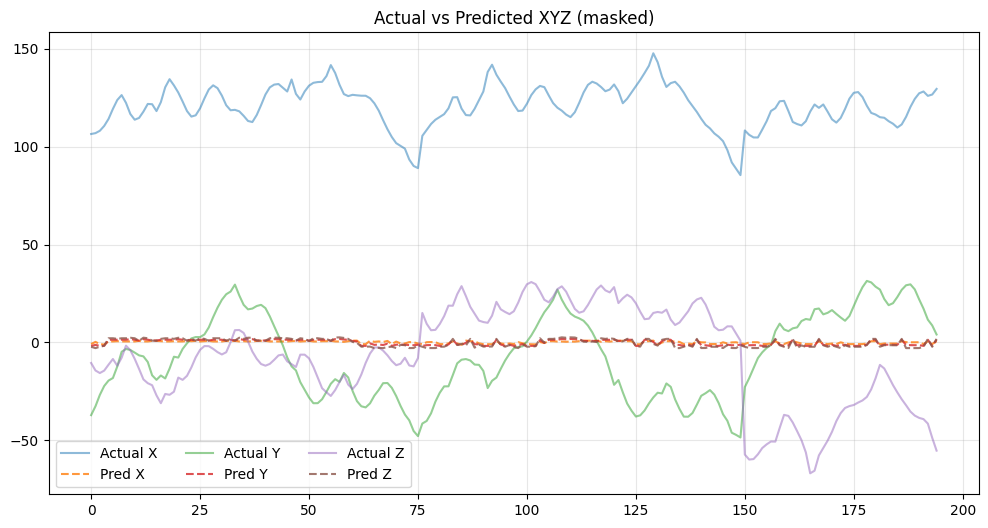

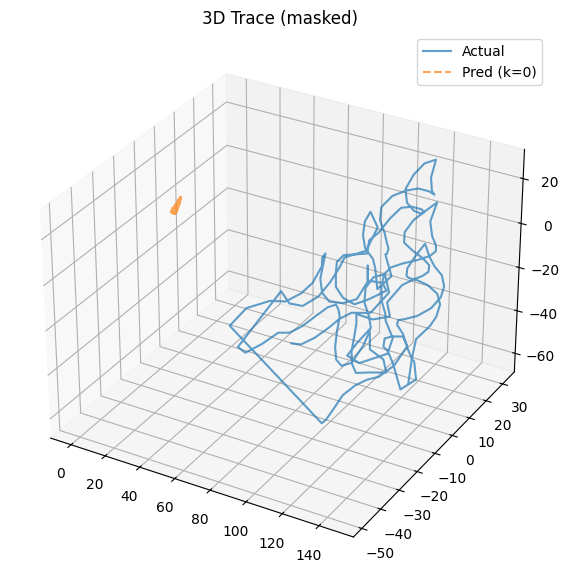

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(t0[:, 0], label="Actual X", alpha=0.7)
plt.plot(p0[:, 0], label="Pred X (k=0)", linestyle="--", alpha=0.9)
plt.title(f"Actual vs Predicted X (valid points={mask0.sum()})")
plt.xlabel("Valid-point Index")
plt.ylabel("X-coordinate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(12, 6))
for i, name in enumerate(["X", "Y", "Z"]):
    plt.plot(t0[:, i], label=f"Actual {name}", alpha=0.5)
    plt.plot(p0[:, i], label=f"Pred {name}", linestyle="--", alpha=0.8)
plt.title("Actual vs Predicted XYZ (masked)")
plt.legend(ncol=3)
plt.grid(alpha=0.3)
plt.show()

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(t0[:, 0], t0[:, 1], t0[:, 2], label="Actual", alpha=0.7)
ax.plot(p0[:, 0], p0[:, 1], p0[:, 2], label="Pred (k=0)", alpha=0.7, linestyle="--")
ax.set_title("3D Trace (masked)")
ax.legend()
plt.show()
